## Histopatholic Cancer Detection Solved with Googlenet CNN Model

In [29]:
import os
import zipfile
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

Loading the dataset labels from a CSV file into a Pandas DataFrame for easier manipulation and analysis.

In [30]:
if not os.path.exists(extracted_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)

train_dir = os.path.join(extracted_dir, "train")
test_dir = os.path.join(extracted_dir, "test")
labels_csv = os.path.join(extracted_dir, "train_labels.csv")

data = pd.read_csv(labels_csv)
print("Dataset loaded successfully")


Dataset loaded successfully


### Exploratoy Data Analysis
Providing an overview of the dataset by displaying its structure, total number of images, and class distribution through text output and a bar plot. Additionally, I am visualizing a random sample of images with their corresponding labels.


Dataset Overview:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Total images: 220025
Class distribution:
label
0    130908
1     89117
Name: count, dtype: int64


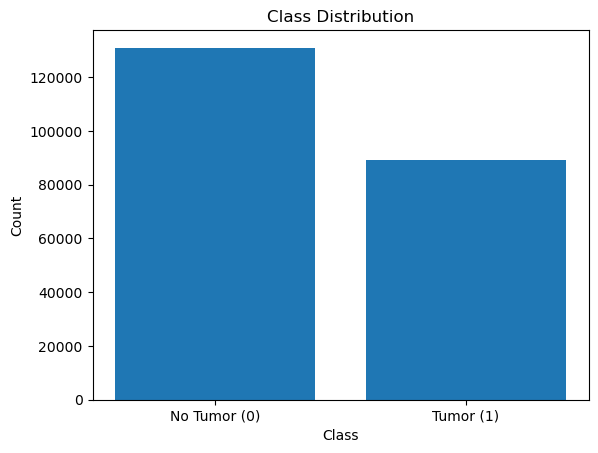

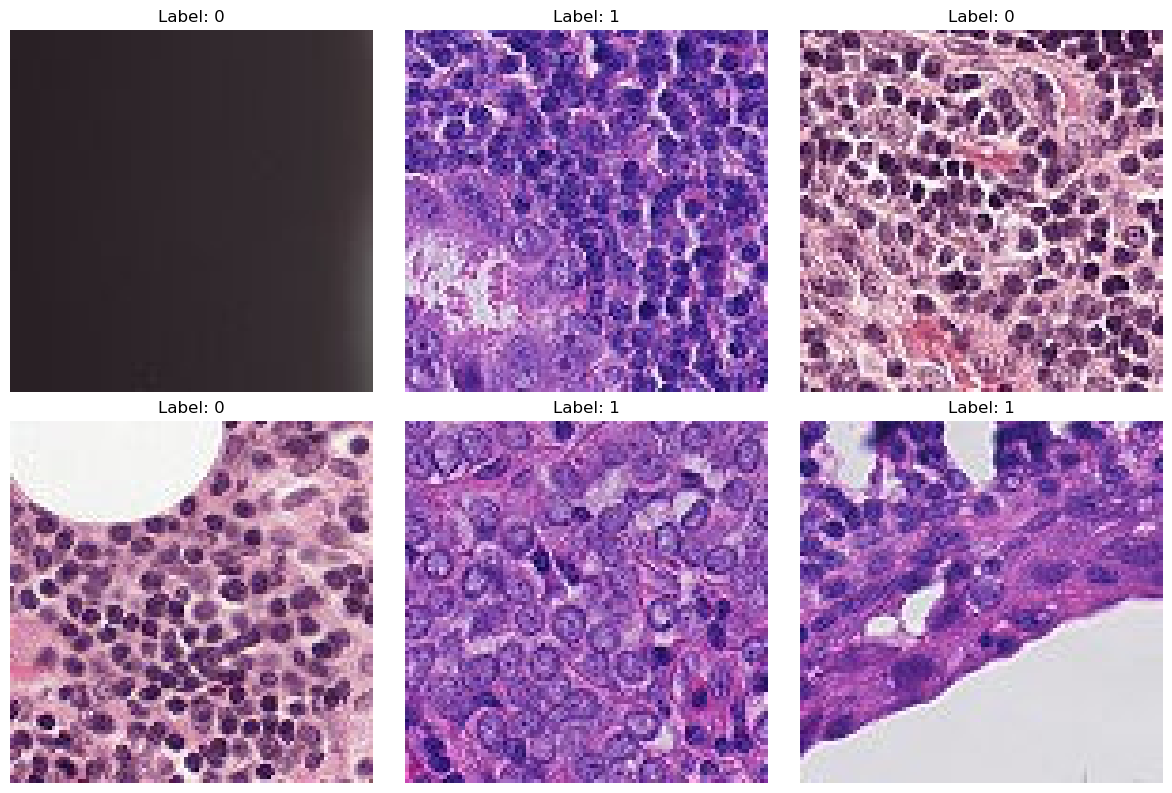

In [31]:
print("Dataset Overview:")
print(data.head())
print(f"Total images: {len(data)}")
print(f"Class distribution:\n{data['label'].value_counts()}")

# Plot class distribution
plt.bar(data['label'].value_counts().index, data['label'].value_counts().values)
plt.xticks([0, 1], ['No Tumor (0)', 'Tumor (1)'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


def display_sample_images(data, base_dir, sample_size=6):
    sample_data = data.sample(sample_size, random_state=42)
    plt.figure(figsize=(12, 8))
    for i, row in enumerate(sample_data.itertuples(), 1):
        img_path = os.path.join(base_dir, f"{row.id}.tif")
        if os.path.exists(img_path):
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) / 255.0
            plt.subplot(2, 3, i)
            plt.imshow(img)
            plt.title(f"Label: {row.label}")
            plt.axis("off")
        else:
            print(f"File not found: {img_path}")
    plt.tight_layout()
    plt.show()

display_sample_images(data, train_dir)


### Data Preprocessing 
This code defines functions to preprocess and load image data, ensuring each image is resized to a fixed size (IMG_SIZE) and normalized. It iterates through a dataset, checking for missing or corrupted image files, and skips them while collecting valid images and their labels into arrays X and y. Finally, it splits the data into training and validation sets using train_test_split for model development and evaluation.

In [32]:
IMG_SIZE = 64
BATCH_SIZE = 32

def preprocess_image(file_path):
    img = cv2.imread(file_path)
    if img is None:
        print(f"Warning: Unable to read image {file_path}. Skipping.")
        return None
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    return img

def load_data(data, base_dir):
    X = []
    y = []
    for _, row in tqdm(data.iterrows(), total=len(data)):
        img_path = os.path.join(base_dir, f"{row['id']}.tif")
        if os.path.exists(img_path):
            img = preprocess_image(img_path)
            if img is not None:  # Skip if the image is corrupted
                X.append(img)
                y.append(row['label'])
        else:
            print(f"Warning: File not found {img_path}. Skipping.")
    return np.array(X), np.array(y)


X, y = load_data(data, train_dir)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

 58%|██████████████████████████████████████████▏                              | 127120/220025 [03:06<01:43, 900.62it/s]

100%|█████████████████████████████████████████████████████████████████████████| 220025/220025 [05:13<00:00, 700.72it/s]


### Hyperparameter Tuning

This code performs hyperparameter tuning to find the optimal number of epochs for training a convolutional neural network. It iteratively trains the model with different epoch values from epoch_grid and evaluates the model's performance using the ROC AUC metric on the validation set. The best model, based on the highest ROC AUC score, is selected, and the results of training, including accuracy and loss over epochs, are visualized using plots.

Testing epochs: 5


C:\Users\klime\anaconda3_new_one\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step
ROC AUC for 5 epochs: 0.9513
Testing epochs: 10


C:\Users\klime\anaconda3_new_one\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step
ROC AUC for 10 epochs: 0.9591
Testing epochs: 15


C:\Users\klime\anaconda3_new_one\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step
ROC AUC for 15 epochs: 0.9584
Best Number of Epochs: 10 with ROC AUC: 0.9591


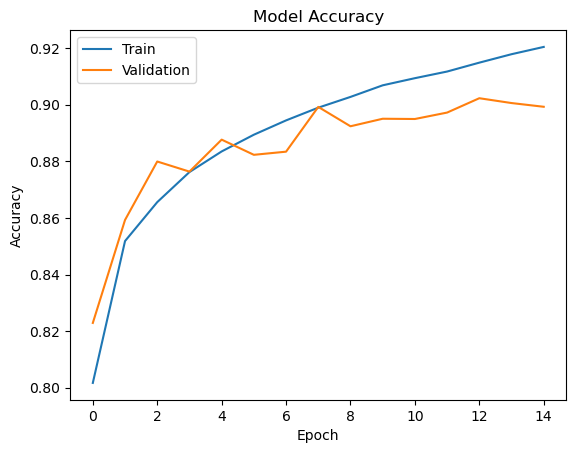

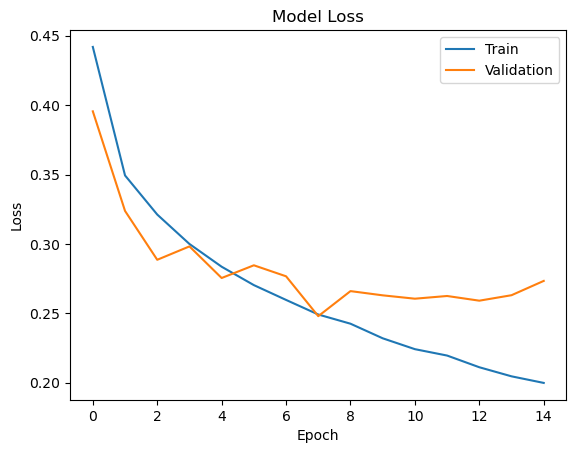

In [33]:
epoch_grid = [5, 10, 15]
best_roc_auc = 0
best_epochs = 0
best_model = None

for epochs in epoch_grid:
    print(f"Testing epochs: {epochs}")
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    training = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=BATCH_SIZE,
        verbose=0
    )
    
    val_preds = model.predict(X_val, batch_size=BATCH_SIZE).flatten()
    roc_auc = roc_auc_score(y_val, val_preds)
    print(f"ROC AUC for {epochs} epochs: {roc_auc:.4f}")
    
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_epochs = epochs
        best_model = model

print(f"Best Number of Epochs: {best_epochs} with ROC AUC: {best_roc_auc:.4f}")

# Plot training results
def plot_training(training, metric):
    plt.figure()
    plt.plot(training.history[metric])
    plt.plot(training.history['val_' + metric])
    plt.title(f'Model {metric.title()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

if training:
    plot_training(training, 'accuracy')
    plot_training(training, 'loss')

### Evaluation on Test Data
This code preprocesses test images by rescaling their pixel values and generates batches for prediction using a pre-trained model. It then predicts labels for the test images, processes the results into binary labels, and organizes them into a DataFrame for submission

In [35]:

def load_test_images(test_dir):
    """
    Load test images from the directory without assuming subdirectories.
    """
    test_images = []
    test_ids = []

    for file in os.listdir(test_dir):
        file_path = os.path.join(test_dir, file)
        if os.path.isfile(file_path) and file.endswith(('.jpg', '.png', '.jpeg', '.tif')):
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
                test_images.append(img)
                test_ids.append(os.path.splitext(file)[0])
            else:
                print(f"Warning: Could not read {file_path}. Skipping.")
    
    return np.array(test_images), test_ids

print("Loading test images...")
X_test, test_ids = load_test_images(test_dir)

if len(X_test) == 0:
    raise ValueError(f"No valid images found in test directory: {test_dir}")

print("Predicting on test data...")
predictions = best_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)

predicted_labels = (predictions > 0.5).astype(int).flatten()

submission_df = pd.DataFrame({
    'id': test_ids,
    'label': predicted_labels
})


submission_csv_path = 'submission.csv'
submission_df.to_csv(submission_csv_path, index=False)
print(f"Submission file created successfully at {submission_csv_path}")

Loading test images...
Predicting on test data...
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step
Submission file created successfully at submission.csv
